<a href="https://colab.research.google.com/github/dtraverso/mri_ml_sandbox/blob/master/MRI_Sandbox1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spinal Cord Gray Matter Segmentation Using PyTorch
In this notebook we are going to explore a medical imaging open-source library known as [MedicalTorch](https://github.com/perone/medicaltorch), which was built on top of PyTorch. MedicalTorch offers many capabilities such as pre-processing of images, transformations, and data loaders. With the tools it is possible to explore and preprocess MRI-based datasets that contain images such as shown in the image below.  

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQmKTAQEz_zoomKa0HchswOUunHQTO3gDoH_VnXfcZdl8N3H0L-aGvM9GqQiiLi-bL0ME4-IoU6cv7g/pub?w=928&h=499)

Image credit: [Perone et al.,2017](https://arxiv.org/pdf/1710.01269.pdf)

## Installing Libraries
Below we will show you how to install the medicaltorch library along with some other libraries.

In [17]:
!pip3 install torch 
!pip3 install torchvision
!pip install medicaltorch
!pip3 install numpy
!pip install tensorboardX

import torch
print(torch.__version__)
import numpy as np
print(np.__version__)

1.2.0
1.16.5


## Mounting Data From Google Drive
I have stored the MRI images on my personal Google Drive, which I acquired from [GM SC Challenge](http://niftyweb.cs.ucl.ac.uk/challenge/index.php#citation) website.

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Library Importation
We need to now import a number of the libraries we downloaded & installed, as well as provide them with shorthand aliases for convienence.

In [0]:
from collections import defaultdict
import time
import os

import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm

from tensorboardX import SummaryWriter

from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn

import torchvision.utils as vutils

cudnn.benchmark = True

### Data Exploration
Before we do any modeling stuff, let's investigate our data first. Let's look at one sample (MRI image) from the dataset. We will see the preprocessing module `mt_datasets.SegmentationPair2D` which is used to read and format the data in a way that we can better explore it in our environment. See the example below.

In [0]:
ROOT_DIR_GMCHALLENGE = "gdrive/My Drive/SANDBOX/medical_imaging/train/"
mri_input_filename = os.path.join(ROOT_DIR_GMCHALLENGE,
                                          'site1-sc01-image.nii.gz')
mri_gt_filename = os.path.join(ROOT_DIR_GMCHALLENGE,
                                       'site1-sc01-mask-r1.nii.gz')

pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
slice_pair = pair.get_pair_slice(0)
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]

In [21]:
print(input_slice.shape)

(100, 100)


Printing the image array shape we can see that the images are 100 X 100 dimensions. We can also view the image in our environment using matplotlib.

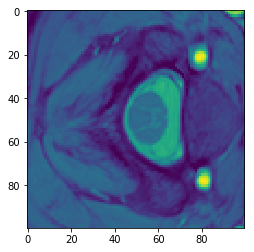

In [22]:
img = input_slice
plt.imshow(img)
plt.show()

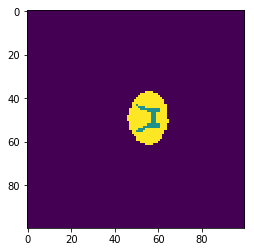

In [23]:
img = gt_slice
plt.imshow(img)
plt.show()

The upper image shows an in vivo axial-slice sample while the lower image shows the spinal cord gray matter segmentation. Intuitively, the dataset contains the necessary information to conduct gray matter segmentation using deep learning techniques such as encode/decoder frameworks and deep convolutional neural networks.

In [24]:
# transformer
composed_transform = transforms.Compose([
            mt_transforms.Resample(0.25, 0.25),
            mt_transforms.CenterCrop2D((200, 200)),
            mt_transforms.ToTensor(),
])

# load data
train_dataset = mt_datasets.SCGMChallenge2DTrain(root_dir=ROOT_DIR_GMCHALLENGE, transform=composed_transform)

# PyTorch data loader
dataloader = DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=4,
                        collate_fn=mt_datasets.mt_collate)

# get minibatch
minibatch = next(iter(dataloader))

# check minibatch size
minibatch['input'].size()

### output
# torch.Size([4, 1, 200, 200])

torch.Size([4, 1, 200, 200])

## Constructing The Segmentation Model
We saw the images above, now we want to build the gray matter segmentation model with the MRI spinal cord images provided above. Let's define a helper function that helps to decide the final predictions of the model.

In [0]:
def threshold_predictions(predictions, thr=0.999):
    thresholded_preds = predictions[:]
    low_values_indices = thresholded_preds < thr
    thresholded_preds[low_values_indices] = 0
    low_values_indices = thresholded_preds >= thr
    thresholded_preds[low_values_indices] = 1
    return thresholded_preds

And here are all the transformations to both the training and validation dataset.



In [0]:
train_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ElasticTransform(alpha_range=(28.0, 30.0),
                                       sigma_range=(3.5, 4.0),
                                       p=0.3),
        mt_transforms.RandomAffine(degrees=4.6,
                                   scale=(0.98, 1.02),
                                   translate=(0.03, 0.03)),
        mt_transforms.RandomTensorChannelShift((-0.10, 0.10)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

val_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

In [0]:
### training dataset with 80/20 split
TRAIN_ROOT_DIR_GMCHALLENGE = "gdrive/My Drive/SANDBOX/medical_imaging/train/"

gmdataset_train = mt_datasets.SCGMChallenge2DTrain(root_dir=TRAIN_ROOT_DIR_GMCHALLENGE,
                                                   subj_ids=range(1, 9),
                                                   transform=train_transform,
                                                   slice_filter_fn=mt_filters.SliceFilter())

gmdataset_val = mt_datasets.SCGMChallenge2DTrain(root_dir=TRAIN_ROOT_DIR_GMCHALLENGE,
                                                 subj_ids=range(9, 11),
                                                 transform=val_transform)

In [28]:
print(len(gmdataset_train))

1423


In [0]:
train_loader = DataLoader(gmdataset_train, batch_size=16,
                          shuffle=True, pin_memory=True,
                          collate_fn=mt_datasets.mt_collate,
                          num_workers=1)

val_loader = DataLoader(gmdataset_val, batch_size=16,
                        shuffle=True, pin_memory=True,
                        collate_fn=mt_datasets.mt_collate,
                        num_workers=1)

### Model and Parameters
Below we declare our model and parameters. Note that we are using GPU in this notebook. Also note that the model used below refers to the U-net convolutional-based architecture proposed by [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597), which essentially aggregates semantic information to perform the segmentation. See a figure of the U-net framework below. You can also refer to the medicaltorch [API documentation](https://medicaltorch.readthedocs.io/en/stable/modules.html#module-medicaltorch.models) for more available state-of-the-art implementations. 

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vT2miqwBsJpm9vX2lH7GRJaMWw3ym9Ld3MNY-10rpKIQJoXvfsRbIu1OpndIn4BJqYUtpq3wZcwmS9v/pub?w=921&h=624)

Image Credit: [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)

In [0]:
model = mt_models.Unet(drop_rate=0.4, bn_momentum=0.1)
model.cuda()
num_epochs = 10
initial_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

Some helper functions to produce the desired metrics for the model such as accuracy.



In [0]:
def numeric_score(prediction, groundtruth):
    FP = np.float(np.sum((prediction == 1) & (groundtruth == 0)))
    FN = np.float(np.sum((prediction == 0) & (groundtruth == 1)))
    TP = np.float(np.sum((prediction == 1) & (groundtruth == 1)))
    TN = np.float(np.sum((prediction == 0) & (groundtruth == 0)))
    return FP, FN, TP, TN 
  
def accuracy(prediction, groundtruth):
    FP, FN, TP, TN = numeric_score(prediction, groundtruth)
    N = FP + FN + TP + TN
    accuracy = np.divide(TP + TN, N)
    return accuracy * 100.0

### Training 
Now we finally train the model for spinal cord gray matter segmentation. We report the training and testing accuracy below and train for 10 epochs only. 

In [32]:
for epoch in tqdm(range(1, num_epochs+1)):
    start_time = time.time()

    scheduler.step()

    lr = scheduler.get_lr()[0]

    model.train()
    train_loss_total = 0.0
    num_steps = 0
    
    ### Training
    for i, batch in enumerate(train_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        var_input = input_samples.cuda()
        var_gt = gt_samples.cuda(async=True)

        preds = model(var_input)

        loss = mt_losses.dice_loss(preds, var_gt)
        train_loss_total += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_steps += 1

        if epoch % 5 == 0:
            grid_img = vutils.make_grid(input_samples,
                                        normalize=True,
                                        scale_each=True)
            

            grid_img = vutils.make_grid(preds.data.cpu(),
                                        normalize=True,
                                        scale_each=True)
            

            grid_img = vutils.make_grid(gt_samples,
                                        normalize=True,
                                        scale_each=True)
   
    
    train_loss_total_avg = train_loss_total / num_steps
    model.eval()
    val_loss_total = 0.0
    num_steps = 0
    train_acc  = accuracy(preds.cpu().detach().numpy(), 
                          var_gt.cpu().detach().numpy())
    
    metric_fns = [mt_metrics.dice_score,
                  mt_metrics.hausdorff_score,
                  mt_metrics.precision_score,
                  mt_metrics.recall_score,
                  mt_metrics.specificity_score,
                  mt_metrics.intersection_over_union,
                  mt_metrics.accuracy_score]

    metric_mgr = mt_metrics.MetricManager(metric_fns)
            
    ### Validating
    for i, batch in enumerate(val_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        with torch.no_grad():
            var_input = input_samples.cuda()
            var_gt = gt_samples.cuda(async=True)

            preds = model(var_input)
            loss = mt_losses.dice_loss(preds, var_gt)
            val_loss_total += loss.item()

        # Metrics computation
        gt_npy = gt_samples.numpy().astype(np.uint8)
        gt_npy = gt_npy.squeeze(axis=1)

        preds = preds.data.cpu().numpy()
        preds = threshold_predictions(preds)
        preds = preds.astype(np.uint8)
        preds = preds.squeeze(axis=1)

        metric_mgr(preds, gt_npy)

        num_steps += 1
        
    metrics_dict = metric_mgr.get_results()
    metric_mgr.reset()
    val_loss_total_avg = val_loss_total / num_steps
   
    print('\nTrain loss: {:.4f}, Training Accuracy: {:.4f} '.format(train_loss_total_avg, train_acc))
    print('Val Loss: {:.4f}, Validation Accuracy: {:.4f} '.format(val_loss_total_avg, metrics_dict["accuracy_score"]))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functi


Train loss: -0.5289, Training Accuracy: 92.2419 
Val Loss: -0.8361, Validation Accuracy: 99.0672 


 20%|██        | 2/10 [03:29<13:58, 104.86s/it]


Train loss: -0.8647, Training Accuracy: 86.8185 
Val Loss: -0.8978, Validation Accuracy: 99.4356 


 30%|███       | 3/10 [05:13<12:12, 104.70s/it]


Train loss: -0.8943, Training Accuracy: 93.2866 
Val Loss: -0.9234, Validation Accuracy: 99.5568 


 40%|████      | 4/10 [06:57<10:27, 104.51s/it]


Train loss: -0.9058, Training Accuracy: 91.0154 
Val Loss: -0.9093, Validation Accuracy: 99.4970 


 50%|█████     | 5/10 [08:46<08:49, 105.86s/it]


Train loss: -0.9135, Training Accuracy: 94.4209 
Val Loss: -0.9261, Validation Accuracy: 99.5721 


 60%|██████    | 6/10 [10:30<07:01, 105.34s/it]


Train loss: -0.9197, Training Accuracy: 97.3552 
Val Loss: -0.9244, Validation Accuracy: 99.5776 


 70%|███████   | 7/10 [12:15<05:15, 105.11s/it]


Train loss: -0.9229, Training Accuracy: 95.9522 
Val Loss: -0.9256, Validation Accuracy: 99.5790 


 80%|████████  | 8/10 [13:59<03:29, 104.95s/it]


Train loss: -0.9274, Training Accuracy: 93.9997 
Val Loss: -0.9228, Validation Accuracy: 99.5714 


 90%|█████████ | 9/10 [15:44<01:44, 104.92s/it]


Train loss: -0.9292, Training Accuracy: 96.7463 
Val Loss: -0.9251, Validation Accuracy: 99.5744 


100%|██████████| 10/10 [17:33<00:00, 106.20s/it]


Train loss: -0.9290, Training Accuracy: 95.0296 
Val Loss: -0.9257, Validation Accuracy: 99.5762 


## Summary
In summary, we learned how to process MRI image scans using a neat and powerful tool known as medicaltorch. In addition, we learned about how to preprocess, prepare and load the data using medicaltorch and PyTorch's build-in DataLoader module. Finally, we trained a model based on convolutional neural networks to conduct spinal cord gray matter segmentation.